In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn

In [2]:
data = pd.read_csv('dataframe.csv')
data.columns
training_features = ['etmiss', 'mtw', 'leadleptPt', 'leadleptEta',
       'leadleptE', 'leadleptPhi', 'n_TopLRjets',
       'leadTopLRjet_pt', 'leadTopLRjet_eta', 'leadTopLRjet_phi',
       'leadTopLRjet_m', 'leadTopLRjet_Tau32', 'n_jets', 'leadjet_pt',
       'leadjet_eta', 'n_bjets', 'leadbjet_pt', 'leadbjet_eta', 'ttbarMLR']
label = "label"

In [3]:
scaler = StandardScaler()
data[training_features] = scaler.fit_transform(data[training_features])

X = scaler.transform(data[training_features])
y = data[label]
w = data['scaleweight']

x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=42)

In [4]:
y_train.shape

(201676,)

In [17]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(torch.device("mps"))
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(torch.device("mps"))
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(torch.device("mps"))
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1).to(torch.device("mps"))
w_train_tensor = torch.tensor(w_train, dtype=torch.float32).to(torch.device("mps"))
w_test_tensor = torch.tensor(w_test.to_numpy(), dtype=torch.float32).to(torch.device("mps"))


In [18]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

print(x_test_tensor.shape[0])
net = Net(x_test_tensor.shape[1]).to(torch.device("mps"))
# Define the loss function and the optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
print(net)
print(f"Training data shape: {x_train_tensor.shape}")
print(f"Testing data shape: {x_test_tensor.shape}")
print(f"Number of parameters: {sum(p.numel() for p in net.parameters())}")

50420
Net(
  (fc1): Linear(in_features=19, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Training data shape: torch.Size([201676, 19])
Testing data shape: torch.Size([50420, 19])
Number of parameters: 5505


In [19]:
def train_and_test(model, X_train, y_train, X_test, y_test, epochs=50):
    """
        Defining the training loop. 
    """
    loss_history = []
    loss_history_test = []
    for _ in range(epochs):
        model.train()                                       # sets the model to training mode.
        optimizer.zero_grad()                               # sets the gradients "to zero".

        y_ = model(X_train)                                 # forward pass (y predicted).
        loss = loss_fn(y_, y_train)                         # computes the loss.
        
        loss_history.append(loss.item())                    # appends the loss to the loss history.

        loss.backward()                                     # computes the gradients.
        optimizer.step()                                    # updates weights using the gradients.
        model.eval()
        with torch.no_grad():
            outputs = model(X_test)                         # forward pass (y predicted).
            test_loss = loss_fn(outputs, y_test)            # computes the loss.
            loss_history_test.append(test_loss.item())      # appends the loss to the loss history.

        print("Epoch: {}, Training Loss: {}, Testing Loss: {}".format(_, loss.item(), test_loss.item()))
    return loss_history, loss_history_test

In [20]:
def evaluate(model, X):
    """
        Evaluating the model. 
    """
    model.eval()  # <-- here
    with torch.no_grad(): 
        y_ = model(X)    
    return y_

In [21]:
loss_history, loss_history_test = train_and_test(net, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs=500)
y_hat = evaluate(net, x_test_tensor)

Epoch: 0, Training Loss: 0.31910455226898193, Testing Loss: 0.2905193865299225
Epoch: 1, Training Loss: 0.29028820991516113, Testing Loss: 0.26302242279052734
Epoch: 2, Training Loss: 0.2628863453865051, Testing Loss: 0.2370922863483429
Epoch: 3, Training Loss: 0.23705428838729858, Testing Loss: 0.2127978503704071
Epoch: 4, Training Loss: 0.21285879611968994, Testing Loss: 0.19015085697174072
Epoch: 5, Training Loss: 0.19030895829200745, Testing Loss: 0.16913078725337982
Epoch: 6, Training Loss: 0.1693868339061737, Testing Loss: 0.14975126087665558
Epoch: 7, Training Loss: 0.15010294318199158, Testing Loss: 0.1320471614599228
Epoch: 8, Training Loss: 0.13249176740646362, Testing Loss: 0.11604893952608109
Epoch: 9, Training Loss: 0.11658287793397903, Testing Loss: 0.10175929963588715
Epoch: 10, Training Loss: 0.10237793624401093, Testing Loss: 0.08915609866380692
Epoch: 11, Training Loss: 0.08985291421413422, Testing Loss: 0.07818984985351562
Epoch: 12, Training Loss: 0.0789608880877494

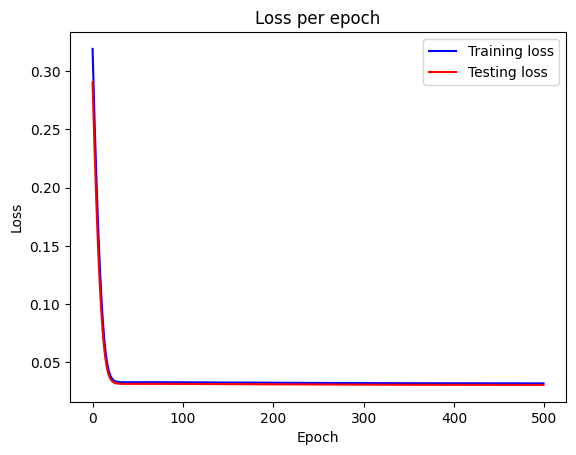

In [22]:
plt.plot(loss_history, label='Training loss', color='blue')
plt.plot(loss_history_test, label='Testing loss', color='red')
plt.title('Loss per epoch');
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()